Reference

xgboost
https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting

Confusion matrix — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 21 October 2018, from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# 1. Split dataset

- 20% of training data becomes the final holdout set (test set)
- 80% will be used to validate models using cross-validation
- 100% of "prior" will be used for model building

In [1]:
import pandas as pd
import os
import seaborn as sns
%matplotlib inline

In [2]:
# Read all the files

data_folder = "input_data/"
proc_data_folder = "processed_data/"


aisles = pd.read_csv(os.path.join(data_folder, "aisles.csv"))
departments = pd.read_csv(os.path.join(data_folder, "departments.csv"))
products = pd.read_csv(os.path.join(data_folder, "products.csv"))


# Sample from the big files for now
# order_prod_prior = pd.read_csv(os.path.join(data_folder, "order_products__prior.csv"))
# order_prod_train = pd.read_csv(os.path.join(data_folder, "order_products__train.csv"))
orders = pd.read_csv(os.path.join(data_folder, "orders.csv"))


In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
orders_train = orders[orders.eval_set == "train"]

In [5]:
from sklearn.model_selection import train_test_split

validation, test = train_test_split(orders_train, test_size=0.2)


In [6]:
validation.to_csv(os.path.join(proc_data_folder, "validation.csv"))
test.to_csv(os.path.join(proc_data_folder, "test.csv"))
del(orders_train,test)

In [7]:
orders.groupby("eval_set").count()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
eval_set,,,,,,
prior,3214874,3214874,3214874,3214874,3214874,3008665
test,75000,75000,75000,75000,75000,75000
train,131209,131209,131209,131209,131209,131209


In [8]:
orders[orders.eval_set == "test"].head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


# 2. Build features

### Product features
- Reorder rate per product (all reorders / all orders per product id) - how popular the product is for reordering 
- Product department, aisle - what kind of product it is 
- popularity per aisle in terms of total orders (rank) - is this the top choice per aisle
TO CHECK:
- some form of generalization from product name (embedding into what space?)
  
### User features  
- Average days between orders - how frequently a user is buying  
- Average basket size (avg. number of products per order) - how many items they put into cart  
- Average reorder share (excl. first order - avg % of reordered items in the basket) - are they prone to reordering 
- Number of distinct products ordered by user overall - do they always order a small number of products

### Order features (already available)
- Days since last the order  
- Time of day of the order  
- Days of week of the order 
- Order number for a given user

In [9]:
orders_prior = orders[orders.eval_set == "prior"]
orders_prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
order_prod_prior = pd.read_csv(os.path.join(data_folder, "order_products__prior.csv"))

In [11]:
order_prod_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


#### Product features

In [12]:
prod_features = order_prod_prior.groupby("product_id").agg({"order_id":"count", "reordered":"sum"})\
.rename(columns={"order_id":"prod_total_orders", "reordered":"prod_total_reorders"})\
.reset_index()

In [13]:
prod_features.head()

,product_id,prod_total_orders,prod_total_reorders
0,1,1852,1136
1,2,90,12
2,3,277,203
3,4,329,147
4,5,15,9


In [14]:
prod_features["prod_reorder_rate"] = prod_features["prod_total_reorders"]/prod_features["prod_total_orders"]

In [15]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [16]:
prod_meta = pd.merge(left=products,right=aisles,on="aisle_id",how="left")
prod_meta = pd.merge(left=prod_meta,right=departments,on="department_id",how="left")

In [17]:
prod_features = pd.merge(prod_features,
                         prod_meta[["product_id","aisle","department"]], on="product_id", how="left")

In [18]:
prod_features.head()

,product_id,prod_total_orders,prod_total_reorders,prod_reorder_rate,aisle,department
0,1,1852,1136,0.613391,cookies cakes,snacks
1,2,90,12,0.133333,spices seasonings,pantry
2,3,277,203,0.732852,tea,beverages
3,4,329,147,0.446809,frozen meals,frozen
4,5,15,9,0.600000,marinades meat preparation,pantry


In [19]:
prod_features["prod_aisle_orders_rank"]= prod_features.groupby(["aisle"])["prod_total_orders"].rank(pct=True)

In [20]:
# Example of the "spreads" aisle
prod_features[prod_features.aisle=="spreads"].sort_values("prod_aisle_orders_rank",ascending=False).head()

,product_id,prod_total_orders,prod_total_reorders,prod_reorder_rate,aisle,department,prod_aisle_orders_rank
30444,30450,21490,12178,0.566682,spreads,pantry,1.000000
16949,16953,20033,10503,0.524285,spreads,pantry,0.997967
43705,43713,18040,10245,0.567905,spreads,pantry,0.995935
42348,42356,15253,7508,0.492231,spreads,pantry,0.993902
37213,37220,11238,5853,0.520822,spreads,pantry,0.991870


#### User features
- Average days between orders - how frequently a user is buying 
- Total number of orders - is this a new or a loyal customer
- Average basket size (avg. number of products per order) - how many items they put into cart  
- Average reorder share (excl. first order - avg % of reordered items in the basket) - are they prone to reordering 
- Number of distinct products ordered by user overall - do they always order a small number of products


In [21]:
orders_prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [22]:
user_features = (orders_prior.groupby("user_id")
                 .agg({"days_since_prior_order":"mean","order_number":"max"})
                 .rename(columns = {"days_since_prior_order":"usr_mean_reorder_delay", 
                                    "order_number":"usr_total_orders"})
                 .reset_index()
                )

In [23]:
user_features.head()

,user_id,usr_mean_reorder_delay,usr_total_orders
0,1,19.555556,10
1,2,15.230769,14
2,3,12.090909,12
3,4,13.750000,5
4,5,13.333333,4


In [24]:
# Unique users in the dataset
user_features["user_id"].nunique()

206209

In [25]:
user_features.describe()

,user_id,usr_mean_reorder_delay,usr_total_orders
count,206209.000000,206209.000000,206209.000000
mean,103105.000000,15.209435,15.590367
std,59527.555167,7.105277,16.654774
min,1.000000,0.000000,3.000000
25%,51553.000000,9.416667,5.000000
50%,103105.000000,14.500000,9.000000
75%,154657.000000,20.285714,19.000000
max,206209.000000,30.000000,99.000000


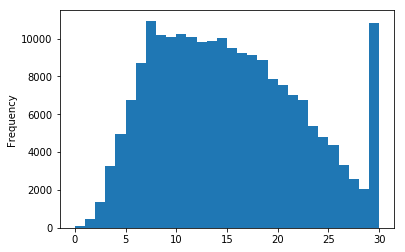

In [26]:
user_features["usr_mean_reorder_delay"].plot.hist(bins=30)

In [27]:
order_prod_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [28]:
order_prod_prior = pd.merge(order_prod_prior, orders_prior[["order_id","user_id"]], on="order_id", how="inner")

In [29]:
user_order_stats = (order_prod_prior.groupby("user_id")
                    .agg({"product_id":"count","reordered":"sum"})
                    .rename(columns={"product_id":"usr_total_products","reordered":"usr_total_reorders"})
                    .reset_index()
                   )

In [30]:
user_features = pd.merge(user_features,user_order_stats,on="user_id", how = "inner")


In [31]:
user_features["usr_reorder_share"] = user_features["usr_total_reorders"]/user_features["usr_total_products"]
user_features["usr_basket_size"] =  user_features["usr_total_products"]/user_features["usr_total_orders"]
user_features.head()

,user_id,usr_mean_reorder_delay,usr_total_orders,usr_total_products,usr_total_reorders,usr_reorder_share,usr_basket_size
0,1,19.555556,10,59,41,0.694915,5.900000
1,2,15.230769,14,195,93,0.476923,13.928571
2,3,12.090909,12,88,55,0.625000,7.333333
3,4,13.750000,5,18,1,0.055556,3.600000
4,5,13.333333,4,37,14,0.378378,9.250000


In [32]:
### Join user product and order features
order_features = orders_prior[["order_id", "user_id", "order_number", "order_dow", "order_hour_of_day", "days_since_prior_order"]]

order_user_features = pd.merge(order_features, user_features, on="user_id", how="inner")

In [33]:
order_user_features.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,usr_mean_reorder_delay,usr_total_orders,usr_total_products,usr_total_reorders,usr_reorder_share,usr_basket_size
0,2539329,1,1,2,8,NaN,19.555556,10,59,41,0.694915,5.9
1,2398795,1,2,3,7,15.0,19.555556,10,59,41,0.694915,5.9
2,473747,1,3,3,12,21.0,19.555556,10,59,41,0.694915,5.9
3,2254736,1,4,4,7,29.0,19.555556,10,59,41,0.694915,5.9
4,431534,1,5,4,15,28.0,19.555556,10,59,41,0.694915,5.9


In [34]:
order_user_features.shape

(3214874, 12)

## SUBSET of 3000 ORDERS TO CHECK XGBOOST

In [179]:
# Generate a sample of 10k user's orders

random.seed(2018)

samples = 10000
all_user_ids = set(orders["user_id"].unique())
sampled_user_ids = sorted(random.sample(all_user_ids,samples))

order_user_features_input = order_user_features[order_user_features["user_id"].isin(sampled_user_ids)]
# order_samp = orders[orders["user_id"].isin(sampled_user_ids)]

In [180]:
# Joining products per order
full_features = pd.merge(order_user_features_input, order_prod_prior, on=["order_id","user_id"], how = "inner")

In [181]:
# Joining product features
full_features = pd.merge(full_features, prod_features, on = "product_id", how = "inner")

In [182]:
full_features.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,usr_mean_reorder_delay,usr_total_orders,usr_total_products,usr_total_reorders,...,usr_basket_size,product_id,add_to_cart_order,reordered,prod_total_orders,prod_total_reorders,prod_reorder_rate,aisle,department,prod_aisle_orders_rank
0,2333706,126923,14,3,18,27.0,16.538462,14,37,29,...,2.642857,19767,1,1,1966,934,0.475076,hot cereal pancake mixes,breakfast,0.950495
1,2907343,154165,8,6,12,30.0,21.857143,8,16,12,...,2.000000,19767,1,1,1966,934,0.475076,hot cereal pancake mixes,breakfast,0.950495
2,2916113,71752,7,5,17,25.0,21.000000,7,20,8,...,2.857143,19767,4,0,1966,934,0.475076,hot cereal pancake mixes,breakfast,0.950495
3,544266,40580,40,5,9,7.0,7.078431,52,134,103,...,2.576923,19767,1,0,1966,934,0.475076,hot cereal pancake mixes,breakfast,0.950495
4,621485,99187,5,4,15,30.0,26.250000,9,57,26,...,6.333333,19767,2,1,1966,934,0.475076,hot cereal pancake mixes,breakfast,0.950495


In [183]:
order_user_features.columns

Index(['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'usr_mean_reorder_delay', 'usr_total_orders',
       'usr_total_products', 'usr_total_reorders', 'usr_reorder_share',
       'usr_basket_size'],
      dtype='object')

### Relationships within user features 

Some logical relationships: the number of total orders is linked to the number of total reorders and unique products ordered.   
1) Strong negative correlation between the delay until a user reorders and item and the total number of reorders. The delay until reorder is also negatively correlated with the reordering status of a product.  
2) Moderately strong positive correlation between the number of total orders and the average share of reordered items - this likely indicates that users with a high number of orders would identify the items they like and keep reordering them. Indeed, the total number of orders is positively correlated with the reordering status of a product.  

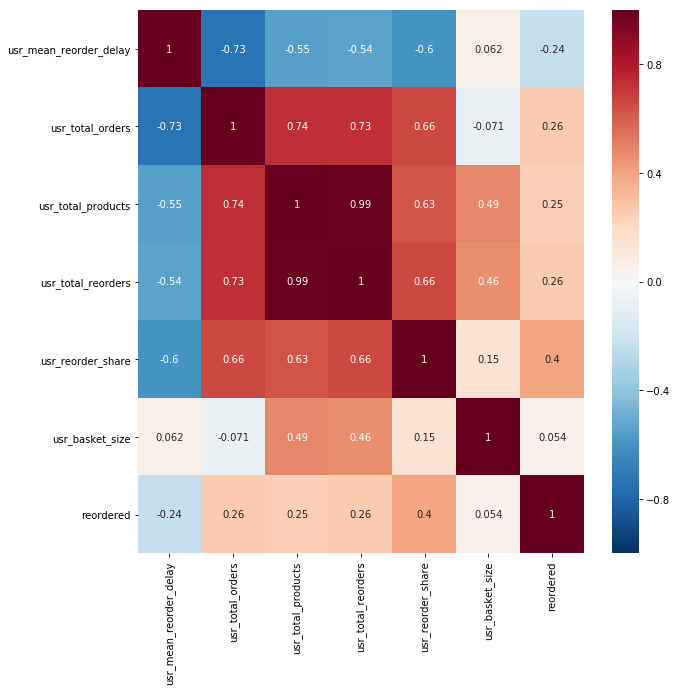

In [184]:
import seaborn as sns
tmp_df = full_features[['usr_mean_reorder_delay', 'usr_total_orders',
       'usr_total_products', 'usr_total_reorders', 'usr_reorder_share',
       'usr_basket_size', "reordered"]]

corr = tmp_df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,
            annot=True, cbar = True,vmin=-1, vmax=1, cmap="RdBu_r")

### Relationships within order features 

The higher the order number of the past ordering of the product, the more likely it is to be reordered. Also, there is a weak negative correlation between the days since the last order, and the product reorder status.

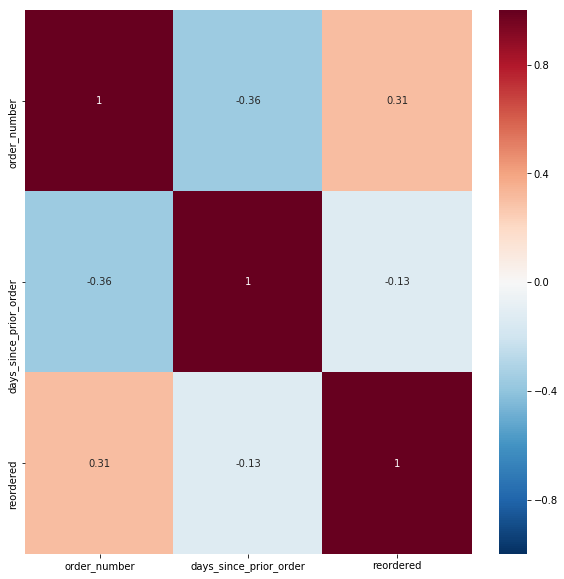

In [185]:
tmp_df = full_features[['order_number','days_since_prior_order', "reordered"]]

corr = tmp_df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,
            annot=True, cbar = True,vmin=-1, vmax=1, cmap="RdBu_r")

### Relationships within product features 

Validated the assumption that the overall reorder rate of a product is positively linked with its reoder status per user. There is a weak positive correlation within product popularity within its sub-department (aisle), and its reorder status.

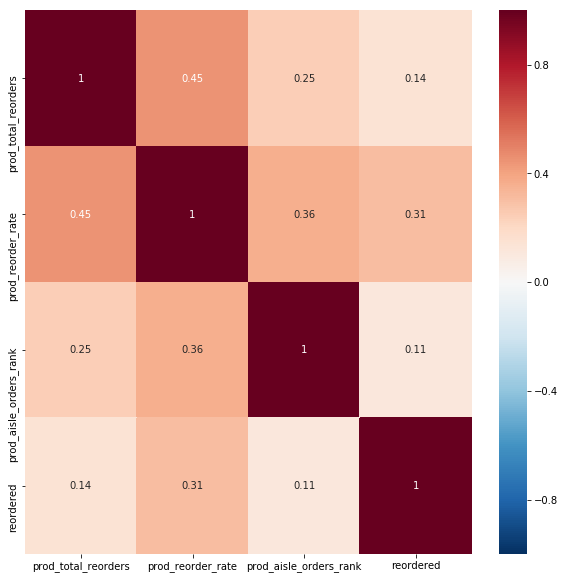

In [186]:
tmp_df = full_features[['prod_total_reorders', 'prod_reorder_rate','prod_aisle_orders_rank', "reordered"]]

corr = tmp_df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,
            annot=True, cbar = True,vmin=-1, vmax=1, cmap="RdBu_r")

In [187]:
full_features.groupby("reordered")["order_id"].count()

reordered
0    37381
1    53204
Name: order_id, dtype: int64

In [188]:
# Before fitting, categorical features need to be one-hot encoded
# Also remove order_id
full_features = pd.get_dummies(full_features, columns=["aisle","department"],drop_first=True)
full_features.columns

Index(['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'usr_mean_reorder_delay', 'usr_total_orders',
       'usr_total_products', 'usr_total_reorders',
       ...
       'department_household', 'department_international',
       'department_meat seafood', 'department_missing', 'department_other',
       'department_pantry', 'department_personal care', 'department_pets',
       'department_produce', 'department_snacks'],
      dtype='object', length=172)

In [189]:
# split data into train and test sets
X = full_features.drop(["reordered", "order_id", "user_id", "product_id"], axis = "columns")
y = full_features["reordered"]

seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [190]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [191]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]

/Users/dima/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [192]:
acc_baseline = y_test.reset_index().groupby("reordered").count()
acc_baseline["class_share"] = acc_baseline["index"]/ acc_baseline["index"].sum()
acc_baseline["class_share"].max()

0.5918750344979853

In [193]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("vs. baseline {:.2%}".format(acc_baseline["class_share"].max().astype("float")))

Accuracy: 77.79%
vs. baseline 59.19%


In [195]:
%run plot_confusion_matrix.py

In [196]:
class_names = ["not reordered", "reordered"]
cnf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

Normalized confusion matrix


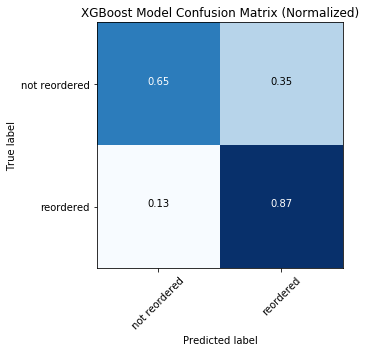

In [210]:
plt.figure()
# plt.rcParams['figure.figsize'] = [5, 5]
fig = plot_confusion_matrix(cnf_matrix, classes=class_names,
                            normalize=True,
                            title='XGBoost Model Confusion Matrix (Normalized)')
# fig.rcParams['figure.figsize'] = [5, 5]

In [198]:
f1_score(y_true=y_test, y_pred=predictions)

0.8218571491830138

In [199]:
### XGBoost feature importance

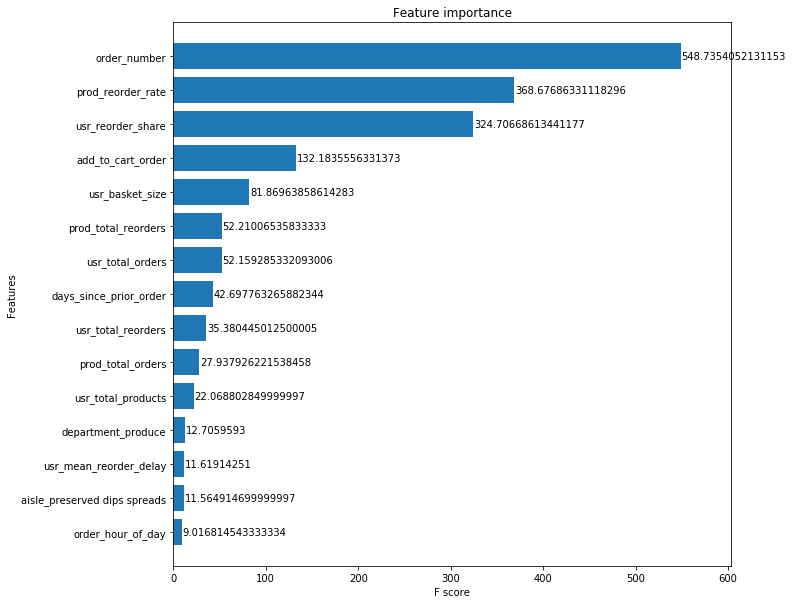

In [205]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

xgboost.plot_importance(model, height = 0.75, max_num_features=15, grid=False,importance_type="gain")
pyplot.show()

In [162]:
# [item for item in X_train.columns]